In [1]:
# all of this from BetterNotebooks.ipynb
import numpy as np
import pandas as pd
pd.set_option("display.precision", 2)
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
import os
from IPython.core.display import HTML

In [121]:
title_approaches = {
    'faircal':'Faircal (Theirs)',
    'gmm-discrete':'GMM-Discrete (Ours)'
    }
title_calibration_methods = {
    'beta': 'Beta Calibration'
}
title_features = {
    'facenet':'FaceNet (VGGFace2)',
    'facenet-webface':'FaceNet (Webface)',
    'arcface': 'ArcFace'}

title_metrics = {
    'mean': 'Mean',
    'aad': 'AAD',
    'mad': 'MAD',
    'std': 'STD'}

caption_metrics = {
     'mean': 'Mean',
     'aad': 'AAD (Average Absolute Deviation)',
     'mad': 'MAD (Maximum Absolute Deviation)',
     'std': 'STD (Standard Deviation)',
}

title_keys = {
    'gmm-discrete': 'GMM-Discrete (Ours)',
    'faircal':'Faircal (Theirs)'
    }

header_titles = {
    'African': 'Af',
    'Asian': 'As',
    'Caucasian': 'Ca',
    'Indian': 'In',
    'asian_females': 'AsF',
    'asian_males': 'AsM',
    'black_females': 'AfF',
    'black_males': 'AfM',
    'indian_females': 'IF',
    'indian_males': 'IM',
    'white_females': 'CF',
    'white_males': 'CM',
    'Global': 'Gl',
    'B': 'Af',
    'A': 'As',
    'W': 'C',
    'I': 'I',
    'F': 'F',
    'M': 'M'
}
title_datasets = {
    'rfw': 'RFW',
    'bfw': 'BFW'
}
caption_calibration_methods = {
    'beta': 'beta calibration'
}
caption_measures = {
    'ks': 'KS',
    'ece': 'ECE',
    'brier': 'Brier',
}
features_datasets = {
#     'rfw': ['facenet', 'facenet-webface'],
    'bfw': ['facenet-webface', 'arcnet']
}
attributes_datasets = {
    'rfw': 'ethnicity',
    'bfw': 'att',
}

In [122]:
def load_measures(dataset, feature, approach, subgroups, att, measure, calibration_method, nbins, n_clusters):
    filename = f'../experiments/{dataset}/{feature}/{approach}/{calibration_method}/nbins_{nbins}'
    filename += f'_nclusters_{n_clusters}'
    
    results = np.load(f'{filename}.npy', allow_pickle=True).item()

    data = pd.DataFrame()
    data['folds'] = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
    data = data.set_index('folds')
    for fold in range(1, 6):
        for j, subgroup in enumerate(subgroups[att]):
            data.loc[f'fold{str(fold)}', f'{subgroup}'] = results[f'fold{str(fold)}'][measure][att][subgroup]
    return data

In [127]:
subgroups = {
            'e':['B', 'A', 'W', 'I'],
            'g':['F','M'],
            'att': ['black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males']
        }
att = 'e'   
test = load_measures('bfw','facenet-webface','faircal',subgroups,att,'ece','beta',25,100)
print(test)

          B     A     W     I
folds                        
fold1  0.02  0.02  0.03  0.03
fold2  0.03  0.02  0.02  0.02
fold3  0.04  0.02  0.02  0.05
fold4  0.03  0.04  0.03  0.02
fold5  0.02  0.03  0.02  0.04


In [128]:
def get_sensitive_attributes_subgroups(dataset):
    if dataset == 'rfw':
        sensitive_attributes = ['ethnicity']
        subgroups = {'ethnicity':['African', 'Asian', 'Caucasian', 'Indian']}
    elif 'bfw' in dataset:
        sensitive_attributes = ['e', 'g', 'att']
        subgroups = {
            'e':['B', 'A', 'W', 'I'],
            'g':['F','M'],
            'att': ['black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males']
        }
    return sensitive_attributes, subgroups

In [129]:
ks = np.array([5,10,15,20,25,50,75,100])
folds = [1,2,3,4,5]
data = pd.DataFrame()

measure = 'ks'
calibration = 'beta'

indices = {
#     'rfw' : {
#         'facenet': ['African', 'Asian', 'Caucasian', 'Indian'],
#         'facenet-webface': ['African', 'Asian', 'Caucasian', 'Indian'],
#     },
    'bfw' : {
        'facenet-webface': ['B', 'A', 'W', 'I', 'F','M', 
            'black_females', 'black_males', 'asian_females', 'asian_males', 'white_females', 'white_males', 'indian_females', 'indian_males']
        }
    }

# Create tuples from multi-indices
approaches = ['faircal', 'gmm-discrete']
tuples = []
for dataset in indices:
    for feature, sens in indices[dataset].items():
        for att in sens:
            for approach in approaches:
                tuples.append((dataset, feature, att, approach))

index = pd.MultiIndex.from_tuples(tuples, names=['dataset', 'feature', 'attribute', 'approach'])

data = pd.DataFrame(index=index)
for metric in ['mean', 'aad', 'mad', 'std']:
    data[metric] = np.nan

# For now, because we only have one experiment
for dataset in indices:
    for feature in indices[dataset]:
        for approach in approaches:
            sensitive_attributes, subgroups = get_sensitive_attributes_subgroups(dataset)
            for att in sensitive_attributes:
                nbins = 25 if dataset == 'bfw' else 10
                data_work = load_measures(dataset, feature, approach, subgroups, att, 'ks', 'beta', nbins=nbins, n_clusters=100)
                data_work = data_work * 100
                for subgroup in data_work.columns:
                    group_mean = data_work[subgroup].mean()
                    data.loc[dataset, feature, subgroup, approach]['mean'] = group_mean
                    data.loc[dataset, feature, subgroup, approach]['aad'] = np.abs(data_work[subgroup] - group_mean).mean()
                    data.loc[dataset, feature, subgroup, approach]['mad'] = np.abs(data_work[subgroup] - group_mean).max()
                    data.loc[dataset, feature, subgroup, approach]['std'] = np.std(data_work[subgroup])

HTML(data.to_html())

In [130]:
def get_overall_stats(calibration_method, nbins, dataset,feature,approach,att,n_clusters,fpr_def):
    filename = f'../experiments/{dataset}/{feature}/{approach}/{calibration_method}/nbins_{nbins}'
    filename += f'_nclusters_{n_clusters}'

    key = 'calibration' if approach in ['faircal', 'baseline', 'gmm-discrete'] else 'pre_calibration'
    
    results = np.load(f'{filename}.npy', allow_pickle=True).item()
    data = pd.DataFrame()
    data['folds'] = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
    data['auc'] = np.nan
    data['fpr_1e-3'] = np.nan
    data['fpr_1e-2'] = np.nan
    data = data.set_index('folds')

    for fold in range(1,6):
        fpr = results['fold'+str(fold)]['fpr'][att]['Global'][key]
        tpr = results['fold'+str(fold)]['tpr'][att]['Global'][key]
        data.loc[f'fold{str(fold)}', 'auc'] = sklearn.metrics.auc(fpr,tpr)
        inter = np.interp(fpr_def, fpr, tpr)
        data.iloc[fold-1, 1:] = inter
    return data

In [135]:
# Accuracy table
keys = ['faircal', 'gmm-discrete']
error = [1e-3, 1e-2]
title_stat = ['AUROC', '0.1\% FPR', '1\% FPR']
n_clusters = [500, 250, 150, 100, 75, 50, 25, 20, 15, 10, 5, 1]
calibration = 'beta'
datasets = ['bfw']

indices = {
#     'rfw' : ['facenet', 'facenet-webface'],
    'bfw' : ['facenet-webface', 'arcface']
}
approaches = ['faircal', 'gmm-discrete']

tuples = []
for dataset in indices:
    for feature in indices[dataset]:
        for cluster in n_clusters:
            for approach in approaches:
                tuples.append((dataset, feature, approach, cluster))

index = pd.MultiIndex.from_tuples(tuples, names=['dataset', 'feature', 'approach', 'clusters'])
data = pd.DataFrame(index=index)
metrics = ['auc', 'fpr_1e-3', 'fpr_1e-2']
for metric in metrics:
    data[metric] = ''

for dataset in indices:
    for feature in indices[dataset]:
        for cluster in n_clusters:
            for approach in approaches:
                nbins = 25 if dataset == 'bfw' else 10
                att = 'att' if dataset == 'bfw' else 'ethnicity'
                data_work = get_overall_stats(calibration, nbins, dataset, feature, approach, att, cluster, error)
                data_work *= 100
                for metric in metrics:
                    mean = round(data_work[metric].mean(), 2)
                    std = round(data_work[metric].std(), 2)
                    data.loc[dataset, feature, approach, cluster][metric] = f'{str(mean)} ({str(std)})'
                
HTML(data.to_html())

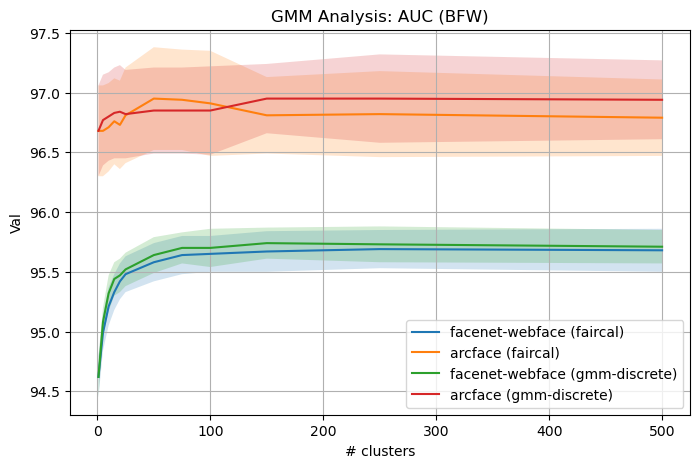

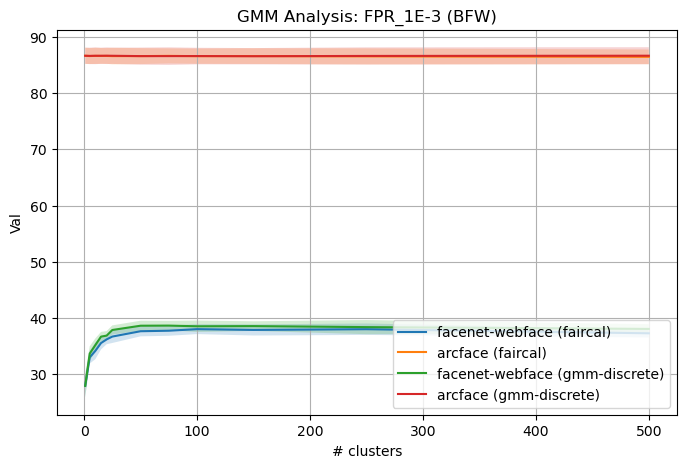

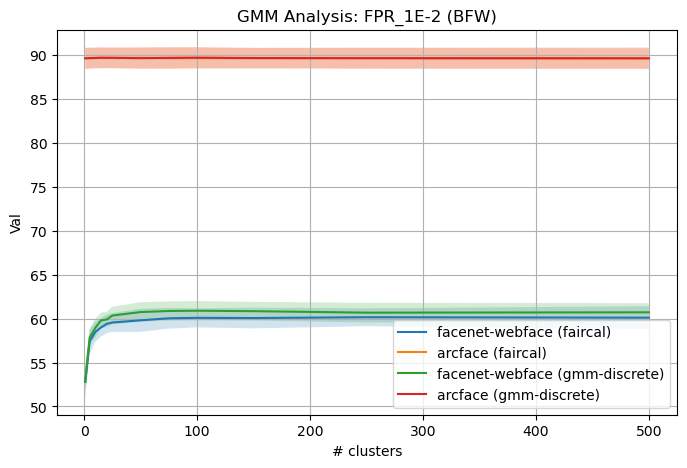

In [138]:
for metric in metrics:
    data[f'{metric}_mean'] = np.nan
    data[f'{metric}_std'] = np.nan
    data[f'{metric}_mean'] = data[metric].apply(lambda x: float(x.split()[0]))
    data[f'{metric}_std'] = data[metric].apply(lambda x: float(x.split()[1][1:-1]))
    data = data.sort_index()
    
    plt.figure(figsize=(8, 5))
    for approach in approaches:
        for model in ["facenet-webface", "arcface"]:
            x = data[f'{metric}_mean']["bfw", model, approach].index
            y = data[f'{metric}_mean']["bfw", model, approach]
            error = data[f'{metric}_std']["bfw", model, approach]
            plt.plot(x,y,label=model+f" ({approach})")
            plt.fill_between(x, y-error, y+error, alpha=0.2)

    plt.legend(loc="lower right")
    plt.grid()
    plt.xlabel("# clusters")
    plt.ylabel("Val")
    plt.title(f"GMM Analysis: {metric.upper()} (BFW)")

    plt.show()

In [181]:
import pandas as pd
gmm_df = pd.read_csv("../times_GMM.txt")
faircal_df = pd.read_csv("../times_faircal.txt")

In [166]:
gmm_df['n_clusters']
faircal_df['n_clusters'] = n_clusters*2

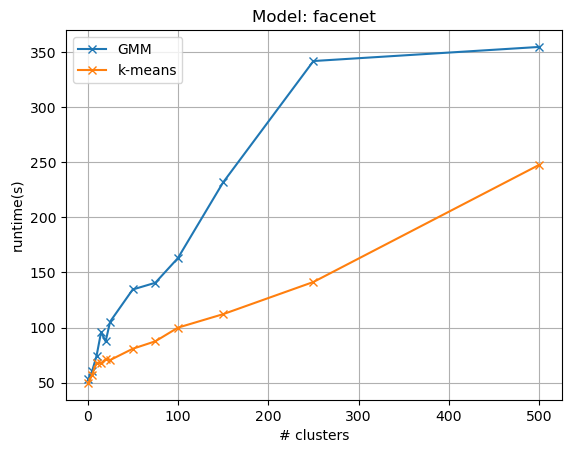

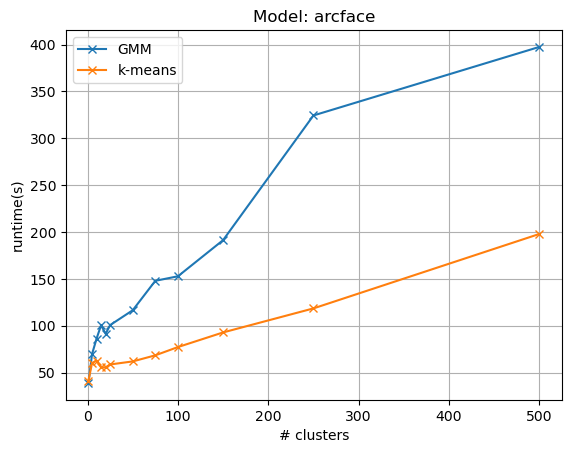

In [193]:
for model in ["facenet", "arcface"]:

    model_gmm = gmm_df[gmm_df["experiment"].str.contains(model)]
    model_faircal = faircal_df[faircal_df["experiment"].str.contains(model)]

    plt.plot(n_clusters, model_gmm["runtime"], marker="x", label="GMM")
    plt.plot(n_clusters, model_faircal["runtime"], marker="x", label="k-means")
    plt.legend()
    plt.grid()
    plt.title(f"Model: {model}")
    plt.ylabel("runtime(s)")
#     plt.xscale("log")
    plt.xlabel("# clusters")
    plt.show()